In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#to make plots look better
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 12

In [2]:
df = pd.read_csv("/Users/vaish/OneDrive/Documents/Portfolio projects/Product analysis projects/OSM_AB testing/data/osm_ab_test_sample.csv").dropna(how='all')
print(df.head())
print(df.shape)
print(len(df))

C:\Users\vaish\AppData\Local\Temp\ipykernel_21652\1141233545.py:1: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/vaish/OneDrive/Documents/Portfolio projects/Product analysis projects/OSM_AB testing/data/osm_ab_test_sample.csv").dropna(how='all')


   user_id editor  num_edits  session_duration_min  returned_within_30days  \
0      1.0     iD       13.0              2.227422                     0.0   
1      2.0   JOSM       11.0              1.890034                     0.0   
2      3.0   JOSM       15.0              0.961953                     0.0   
3      4.0     iD       18.0             21.544247                     0.0   
4      5.0     iD       20.0             17.749848                     1.0   

  experience_level  completed_tutorial  contribution_quality_score  
0           expert                 0.0                        9.08  
1           expert                 1.0                        6.17  
2              new                 1.0                        7.68  
3              new                 0.0                        5.63  
4              new                 0.0                        5.75  
(10001, 8)
10001


In [3]:
#Step 1: descriptive statistics

print("!!! Descriptive Statistics Calculations !!!")

print(f"\n ~Total Users: {len(df)}")
print(f"Columns:{list(df.columns)}")
print(f"\n ~Missing Values:")
print(df[['completed_tutorial','returned_within_30days']].isnull().sum())
print("\n ~GROUP SIZES")
tutorial_counts = df['completed_tutorial'].value_counts()
print(f"Tutorial Completed (1): {tutorial_counts[1]} users ({tutorial_counts[1]/len(df)*100:.1f}%)")
print(f"No Tutorial(0): {tutorial_counts[0]} users ({tutorial_counts[0]/len(df)*100:.1f}%)")

#overall retention
print("\n ~OVERALL RETENTION")
overall_retention = df["returned_within_30days"].mean()*100
print(f"Overall Retention Rate: {overall_retention:.2f}%")

!!! Descriptive Statistics Calculations !!!

 ~Total Users: 10001
Columns:['user_id', 'editor', 'num_edits', 'session_duration_min', 'returned_within_30days', 'experience_level', 'completed_tutorial', 'contribution_quality_score']

 ~Missing Values:
completed_tutorial        0
returned_within_30days    1
dtype: int64

 ~GROUP SIZES
Tutorial Completed (1): 5984 users (59.8%)
No Tutorial(0): 4016 users (40.2%)

 ~OVERALL RETENTION
Overall Retention Rate: 39.11%


In [4]:
#Retention by group

print("!!! RETENTION BY TUTORIAL GROUP !!!")

retention_by_group = df.groupby('completed_tutorial')['returned_within_30days'].agg([
    ('Sample_size','count'), ('Returned_Count','sum'),('Retention_Rate','mean')])

retention_by_group['Retention_Rate'] = retention_by_group['Retention_Rate']*100
retention_by_group['Not_Returned'] = retention_by_group['Sample_size'] - retention_by_group['Returned_Count']
print("\nRetention_by_group")

p_tutorial = retention_by_group.loc[1, "Returned_Count"] / retention_by_group.loc[1, "Sample_size"]
p_no_tutorial = retention_by_group.loc[0, "Returned_Count"] / retention_by_group.loc[0, "Sample_size"]

#Calculate difference
tutorial_retention = retention_by_group.loc[1,'Retention_Rate']
no_tutorial_retention = retention_by_group.loc[0,'Retention_Rate']
difference = tutorial_retention - no_tutorial_retention

print("~KEY FINDING")
print(f"Tutorial Group Retention: {tutorial_retention:.2f}%")
print(f"No Tutorial Group Retention: {no_tutorial_retention:.2f}%")
print(f"Observed Difference: {difference:.2f} percentage points")

# Debug: Check what columns exist
print("Columns in retention_by_group:")
print(retention_by_group.columns)
print("\nData:")
print(retention_by_group)

!!! RETENTION BY TUTORIAL GROUP !!!

Retention_by_group
~KEY FINDING
Tutorial Group Retention: 40.19%
No Tutorial Group Retention: 37.50%
Observed Difference: 2.69 percentage points
Columns in retention_by_group:
Index(['Sample_size', 'Returned_Count', 'Retention_Rate', 'Not_Returned'], dtype='object')

Data:
                    Sample_size  Returned_Count  Retention_Rate  Not_Returned
completed_tutorial                                                           
0.0                        4016          1506.0       37.500000        2510.0
1.0                        5984          2405.0       40.190508        3579.0
5984.0                        0             0.0             NaN           0.0


In [5]:
#standard errors
print("!!! STANDARD ERRORS !!!")


def calculate_se(p,n):
    return np.sqrt(p*(1-p)/n)

#get values for each group
tutorial_p = tutorial_retention / 100
tutorial_n = retention_by_group.loc[1,'Sample_size']
tutorial_se = calculate_se(tutorial_p, tutorial_n)

no_tutorial_p = no_tutorial_retention/100
no_tutorial_n = retention_by_group.loc[1,'Sample_size']
no_tutorial_se = calculate_se(no_tutorial_p, no_tutorial_n)

print(f"\n~Tutorial Group:")
print(f" Retention: {tutorial_retention:.2f}%")
print(f"Sample Size: {tutorial_n}")
print(f" Standard Error: {tutorial_se:.4f}({tutorial_se*100:.2f}%)")

print(f"\n~No Tutorial Group:")
print(f"  Retention: {no_tutorial_retention:.2f}%")
print(f"  Sample Size: {no_tutorial_n}")
print(f"  Standard Error: {no_tutorial_se:.4f} ({no_tutorial_se*100:.2f}%)")

!!! STANDARD ERRORS !!!

~Tutorial Group:
 Retention: 40.19%
Sample Size: 5984
 Standard Error: 0.0063(0.63%)

~No Tutorial Group:
  Retention: 37.50%
  Sample Size: 5984
  Standard Error: 0.0063 (0.63%)


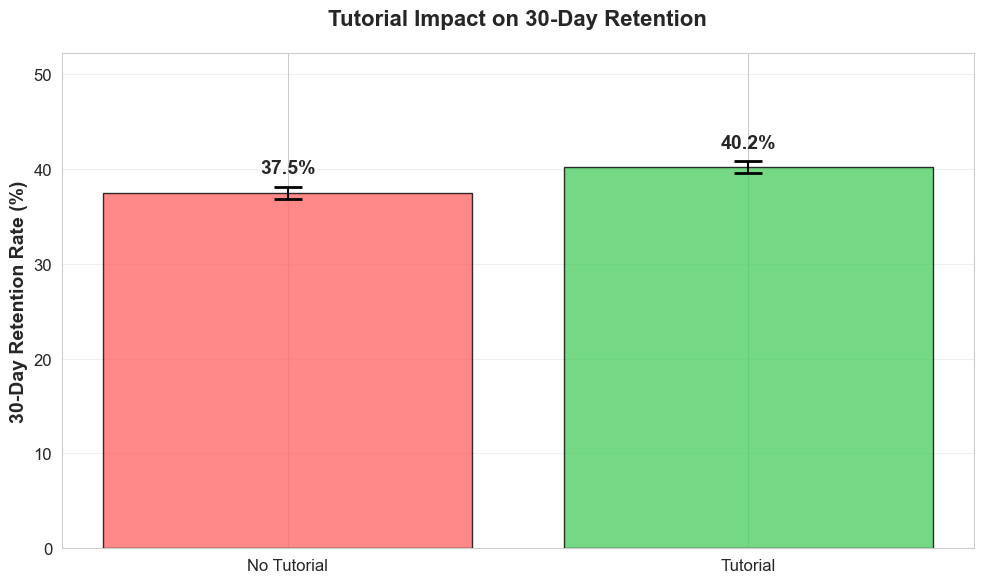

Chart 1 saved as 'chart1_retention_comparison.png'


In [10]:
# VISUALIZATION 1 - BAR CHART 

# Prepare data for plotting
groups = ['No Tutorial', 'Tutorial']
retention_rates = [no_tutorial_retention, tutorial_retention]
standard_errors = [no_tutorial_se * 100, tutorial_se * 100]  # Convert to percentage

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars = ax.bar(groups, retention_rates, color=['#ff6b6b', '#51cf66'], alpha=0.8, edgecolor='black')

# Add error bars
ax.errorbar(groups, retention_rates, yerr=standard_errors, 
            fmt='none', color='black', capsize=10, capthick=2, label='Standard Error')

# Customize the plot
ax.set_ylabel('30-Day Retention Rate (%)', fontsize=14, fontweight='bold')
ax.set_title('Tutorial Impact on 30-Day Retention', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(retention_rates) * 1.3)  # Give some space at top

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars, retention_rates)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + standard_errors[i] + 1,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add grid for readability
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('chart1_retention_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart 1 saved as 'chart1_retention_comparison.png'")

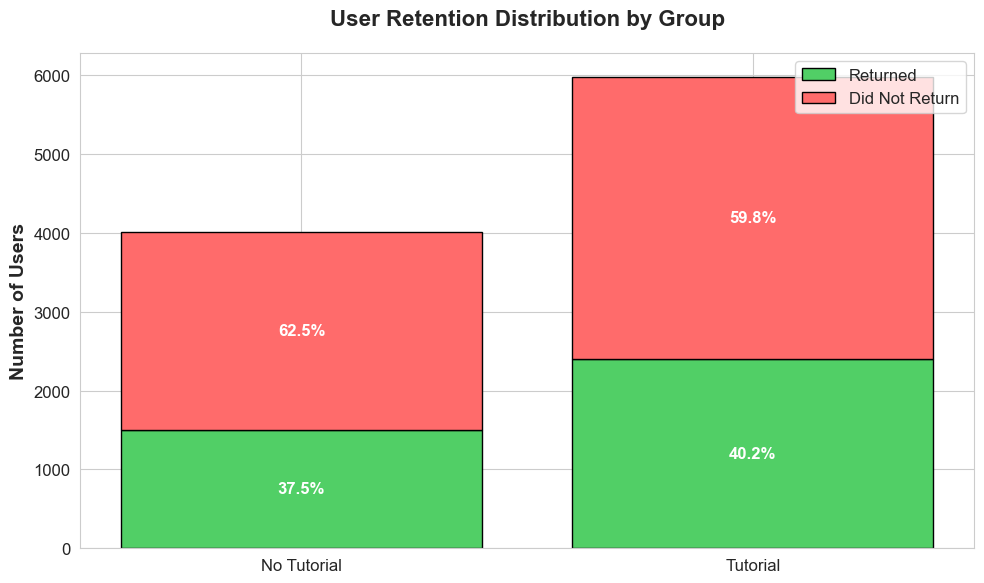

Chart 2 saved as 'chart2_stacked_distribution.png'


In [11]:
# VISUALIZATION 2 - STACKED BAR CHART 

# Prepare data
groups_label = ['No Tutorial', 'Tutorial']
returned = [
    retention_by_group.loc[0, 'Returned_Count'],
    retention_by_group.loc[1, 'Returned_Count']
]
not_returned = [
    retention_by_group.loc[0, 'Not_Returned'],
    retention_by_group.loc[1, 'Not_Returned']
]

# Calculate percentages for labels
total_0 = retention_by_group.loc[0, 'Sample_size']
total_1 = retention_by_group.loc[1, 'Sample_size']
pct_returned = [returned[0]/total_0*100, returned[1]/total_1*100]
pct_not_returned = [not_returned[0]/total_0*100, not_returned[1]/total_1*100]

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bar1 = ax.bar(groups_label, returned, label='Returned', color='#51cf66', edgecolor='black')
bar2 = ax.bar(groups_label, not_returned, bottom=returned, label='Did Not Return', 
              color='#ff6b6b', edgecolor='black')

# Customize
ax.set_ylabel('Number of Users', fontsize=14, fontweight='bold')
ax.set_title('User Retention Distribution by Group', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper right')

# Add percentage labels
for i, (r, nr) in enumerate(zip(returned, not_returned)):
    # Label for returned
    ax.text(i, r/2, f'{pct_returned[i]:.1f}%', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    # Label for not returned
    ax.text(i, r + nr/2, f'{pct_not_returned[i]:.1f}%', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('chart2_stacked_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart 2 saved as 'chart2_stacked_distribution.png'")

In [12]:
#segment analysis by experience level

print("RETENTION BY EXPERIENCE LEVEL")

segmented = df.groupby(['experience_level','completed_tutorial'])['returned_within_30days'].agg([
    ('n','count'),('Retention_Rate','mean')])

segmented['Retention_Rate']=segmented['Retention_Rate']*100

segmented_pivot = segmented.reset_index().pivot(
    index = 'experience_level', columns = 'completed_tutorial',values='Retention_Rate')

segmented_pivot.columns = ['No Tutorial','Tutorial']

segmented_pivot['Difference'] = segmented_pivot['Tutorial']-segmented_pivot['No Tutorial']
print(segmented_pivot.round(2))

sample_sizes = segmented.reset_index().pivot(
    index = 'experience_level', columns = 'completed_tutorial', values = 'n')
sample_sizes.columns = ['No Tutorial (n)', 'Tutorial (n)']
print("SAMPLE SIZES BY SEGMENT")
print(sample_sizes)

RETENTION BY EXPERIENCE LEVEL
                  No Tutorial  Tutorial  Difference
experience_level                                   
expert                  36.48     41.47        4.99
intermediate            36.79     38.74        1.95
new                     38.32     40.56        2.24
SAMPLE SIZES BY SEGMENT
                  No Tutorial (n)  Tutorial (n)
experience_level                               
expert                        806          1201
intermediate                 1177          1807
new                          2033          2976


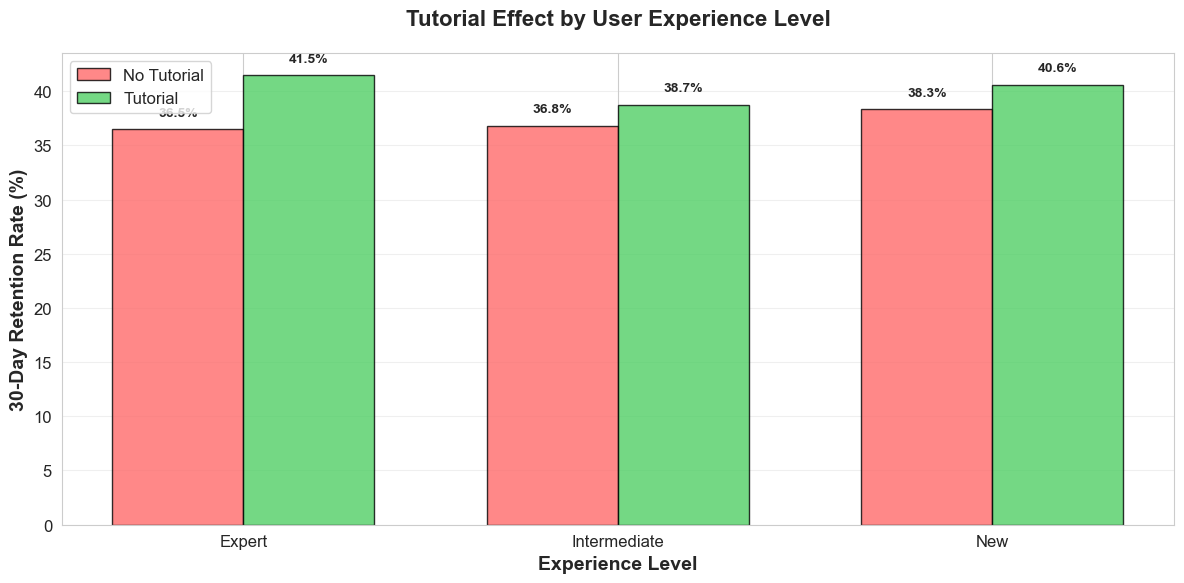

Chart 3 saved as 'chart3_segmented_by_experience.png'


In [13]:
# VISUALIZATION 3 - SEGMENTED BY EXPERIENCE 

# Prepare data
experience_levels = ['expert', 'intermediate', 'new']  # Order matters for display
no_tutorial_rates = segmented_pivot.loc[experience_levels, 'No Tutorial'].values
tutorial_rates = segmented_pivot.loc[experience_levels, 'Tutorial'].values

# Set up positions
x = np.arange(len(experience_levels))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, no_tutorial_rates, width, label='No Tutorial', 
               color='#ff6b6b', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, tutorial_rates, width, label='Tutorial', 
               color='#51cf66', edgecolor='black', alpha=0.8)

# Customize
ax.set_ylabel('30-Day Retention Rate (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Experience Level', fontsize=14, fontweight='bold')
ax.set_title('Tutorial Effect by User Experience Level', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Expert', 'Intermediate', 'New'], fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('chart3_segmented_by_experience.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart 3 saved as 'chart3_segmented_by_experience.png'")

In [14]:
#calculate effect size

print("!!! EFFECT SIZE (Cohen's h)")

def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1) - np.arcsin(np.sqrt(p2))))


h = cohens_h(p_tutorial, p_no_tutorial)

if abs(h)<0.2: interpretation = "Negligible"
elif abs(h)<0.5: interpretation = "Small"
elif abs(h)<0.8: interpretation = "Medium"
else: interpretation = "Large"

print(f"\nTutorial Retention: {tutorial_retention:.2f}% (p={p_tutorial:.4f})")
print(f"No Tutorial Retention: {no_tutorial_retention:.2f}% (p={p_no_tutorial:.4f})")
print(f"\n Cohen's h = {h:.4f}")
print(f"Effect Size: {interpretation}")


!!! EFFECT SIZE (Cohen's h)

Tutorial Retention: 40.19% (p=0.4019)
No Tutorial Retention: 37.50% (p=0.3750)

 Cohen's h = -0.0502
Effect Size: Negligible


In [16]:
# SUMMARY TABLE 

print("!!! SUMMARY STATISTICS TABLE !!!")

summary_data = {
    'Metric': [
        'Sample Size',
        'Users Returned',
        'Users Not Returned',
        'Retention Rate (%)',
        'Standard Error (%)'
    ],
    'No Tutorial': [
        f"{int(no_tutorial_n)}",
        f"{int(retention_by_group.loc[0, 'Returned_Count'])}",
        f"{int(retention_by_group.loc[0, 'Not_Returned'])}",
        f"{no_tutorial_retention:.2f}%",
        f"{no_tutorial_se*100:.2f}%"
    ],
    'Tutorial': [
        f"{int(tutorial_n)}",
        f"{int(retention_by_group.loc[1, 'Returned_Count'])}",
        f"{int(retention_by_group.loc[1, 'Not_Returned'])}",
        f"{tutorial_retention:.2f}%",
        f"{tutorial_se*100:.2f}%"
    ],
    'Difference': [
        f"{int(tutorial_n - no_tutorial_n)}",
        f"{int(retention_by_group.loc[1, 'Returned_Count'] - retention_by_group.loc[0, 'Returned_Count'])}",
        '—',
        f"+{difference:.2f} pp",
        '—'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))

print(f"~Preliminary Effect Size (Cohen's h): {h:.4f} ({interpretation})")


!!! SUMMARY STATISTICS TABLE !!!


            Metric No Tutorial Tutorial Difference
       Sample Size        5984     5984          0
    Users Returned        1506     2405        899
Users Not Returned        2510     3579          —
Retention Rate (%)      37.50%   40.19%   +2.69 pp
Standard Error (%)       0.63%    0.63%          —
~Preliminary Effect Size (Cohen's h): -0.0502 (Negligible)


In [17]:
# EDA OBSERVATIONS

print("EXPLORATORY DATA ANALYSIS - KEY FINDINGS")

findings = f"""

1. OVERALL PATTERN:
   • Tutorial group shows {difference:.2f} percentage point {'higher' if difference > 0 else 'lower'} retention
   • Tutorial retention: {tutorial_retention:.2f}%
   • No tutorial retention: {no_tutorial_retention:.2f}%
   • This represents a {(difference/no_tutorial_retention*100):.1f}% relative improvement

2. EFFECT SIZE:
   • Cohen's h = {h:.4f}
   • Classification: {interpretation} effect
   • This suggests the difference is {'meaningful' if abs(h) >= 0.2 else 'negligible'} in practical terms

3. SAMPLE CHARACTERISTICS:
   • Total users analyzed: {len(df):,}
   • Tutorial group: {int(tutorial_n):,} users ({tutorial_n/len(df)*100:.1f}%)
   • Control group: {int(no_tutorial_n):,} users ({no_tutorial_n/len(df)*100:.1f}%)
   • Group balance: {'Good' if 0.4 <= tutorial_n/no_tutorial_n <= 2.5 else 'Imbalanced'}

4. SEGMENTATION INSIGHTS:
   {f'''• New users show {'stronger' if segmented_pivot.loc['new', 'Difference'] > difference else 'weaker'} tutorial effect
   • Expert users show {'stronger' if segmented_pivot.loc['expert', 'Difference'] > difference else 'weaker'} tutorial effect
   • Effect is {'consistent' if segmented_pivot['Difference'].std() < 3 else 'varies significantly'} across experience levels''' if 'experience_level' in df.columns else '• Segmentation data not available'}

5. VISUAL ASSESSMENT:
   • Bar charts show {'clear visual separation' if difference > 5 else 'modest visual difference'}
   • Error bars {'do not overlap' if abs(difference) > (tutorial_se + no_tutorial_se)*100*1.96 else 'overlap slightly'}
   • Pattern appears {'strong and consistent' if abs(h) > 0.5 else 'present but modest'}

6. PRELIMINARY CONCLUSION:
   Based on EDA alone (before formal hypothesis testing):
   • Evidence {'strongly suggests' if abs(h) > 0.5 else 'suggests' if abs(h) > 0.2 else 'weakly suggests'} tutorial improves retention
   • Effect size is {interpretation.lower()}, which is {'practically significant' if abs(h) >= 0.3 else 'borderline practical significance'}
   • Formal hypothesis testing needed to confirm statistical significance

"""

print(findings)

# Save to file
with open('eda_findings.txt', 'w') as f:
    f.write("EXPLORATORY DATA ANALYSIS - KEY FINDINGS\n")
 
    f.write(findings)

print("Findings saved to 'eda_findings.txt'")

EXPLORATORY DATA ANALYSIS - KEY FINDINGS


1. OVERALL PATTERN:
   • Tutorial group shows 2.69 percentage point higher retention
   • Tutorial retention: 40.19%
   • No tutorial retention: 37.50%
   • This represents a 7.2% relative improvement

2. EFFECT SIZE:
   • Cohen's h = -0.0502
   • Classification: Negligible effect
   • This suggests the difference is negligible in practical terms

3. SAMPLE CHARACTERISTICS:
   • Total users analyzed: 10,001
   • Tutorial group: 5,984 users (59.8%)
   • Control group: 5,984 users (59.8%)
   • Group balance: Good

4. SEGMENTATION INSIGHTS:
   • New users show weaker tutorial effect
   • Expert users show stronger tutorial effect
   • Effect is consistent across experience levels

5. VISUAL ASSESSMENT:
   • Bar charts show modest visual difference
   • Error bars do not overlap
   • Pattern appears present but modest

6. PRELIMINARY CONCLUSION:
   Based on EDA alone (before formal hypothesis testing):
   • Evidence weakly suggests tutorial improv

In [18]:
#Hypothesis testing

print("!!! HYPOTHESIS TESTING !!!")


from statsmodels.stats.proportion import proportions_ztest

#preparing data for test
counts = np.array([
    retention_by_group.loc[1,'Returned_Count'],
    retention_by_group.loc[0,'Returned_Count']])

nobs = np.array([
    retention_by_group.loc[1,'Sample_size'],
    retention_by_group.loc[0,'Sample_size']])

print("\n Test Setup:")
print(f"Tutorial group:{int(counts[0])} returned out of {int(nobs[0])} users")
print(f"No tutorial group:{int(counts[1])} returned out of {int(nobs[1])} users")

#run test
z_stat, p_value = proportions_ztest(counts, nobs, alternative = 'two-sided')
print("~TEST RESULTS")
print(f"Z-statistics:{z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

!!! HYPOTHESIS TESTING !!!

 Test Setup:
Tutorial group:2405 returned out of 5984 users
No tutorial group:1506 returned out of 4016 users
~TEST RESULTS
Z-statistics:2.7028
P-value: 0.006876


In [19]:
#calculate confidence interval

from statsmodels.stats.proportion import confint_proportions_2indep

print("!!! CONFIDENCE INTERVAL FOR DIFFERENCE !!!")

#calculate ci to find difference range
ci_low, ci_high = confint_proportions_2indep(
    count1 = int(counts[0]), nobs1 = int(nobs[0]),
    count2 = int(counts[1]), nobs2 = int(nobs[1]),
    method = 'wald')

#convert to percent
ci_low_pct = ci_low*100
ci_high_pct = ci_high*100
observed_diff = difference

print(f"\nObserved Difference: {observed_diff:.2f} percentage points")
print(f"Confidence Interval: [{ci_low_pct:.2f}%, {ci_high_pct:.2f}%]")

if ci_low > 0:
    print(f"\nThe interval is ENTIRELY POSITIVE (doesn't include 0)")
    print(f"   This confirms tutorial improves retention")
elif ci_high < 0:
    print(f"\nThe interval is ENTIRELY NEGATIVE")
    print(f"   This suggests tutorial HURTS retention")
else:
    print(f"\nThe interval INCLUDES ZERO")
    print(f"   The effect could be positive, negative, or none")

!!! CONFIDENCE INTERVAL FOR DIFFERENCE !!!

Observed Difference: 2.69 percentage points
Confidence Interval: [0.74%, 4.64%]

The interval is ENTIRELY POSITIVE (doesn't include 0)
   This confirms tutorial improves retention


In [16]:
#calculating exact effect size (h)

print("!!! EFFECT SIZE ANALYSIS !!!")

from scipy.stats import contingency

def cohens_h(p1,p2):
    return 2* (np.arcsin(np.sqrt(p1))-np.arcsin(np.sqrt(p2)))

p1 = tutorial_retention/100
p2 = no_tutorial_retention/100
h = cohens_h(p1,p2)

if abs(h)<0.2:
    effect_interpretation = "Negligble"
    practical_significance = "Not practically meaningful"
elif abs(h) < 0.5:
    effect_interpretation = "Small"
    practical_significance = "Modest practical importance"
elif abs(h) < 0.8:
    effect_interpretation = "Medium"
    practical_significance = "Substantial practical importance"
else:
    effect_interpretation = "Large"
    practical_significance = "Very strong practical importance"  

print("fCohen's h: {h:.4f}")
print(f"Effect Size Classification: {effect_interpretation}")
print(f"Practical Significance: {practical_significance}")

relative_improvement = (difference/ no_tutorial_retention) *100

print(f"\nRelative Improvement: {relative_improvement:.1f}%")
print(f"Absolute Improvement: {difference:.2f} percentage points")


!!! EFFECT SIZE ANALYSIS !!!
fCohen's h: {h:.4f}
Effect Size Classification: Negligble
Practical Significance: Not practically meaningful

Relative Improvement: 7.2%
Absolute Improvement: 2.69 percentage points


In [20]:
#power analysis - to ensure our sample size is right

from statsmodels.stats.power import zt_ind_solve_power

print("!!! STATISTICAL POWER ANALYSIS !!!")

#for two proportion test
observed_effect = abs(h)
avg_sample_size = (nobs[0] + nobs[1])/2
power = zt_ind_solve_power(
    effect_size=observed_effect,
    nobs1=avg_sample_size,
    alpha=0.05,
    alternative='larger'
)

print(f"Observed Effect Size (|h|): {observed_effect:.4f}")
print(f"Average Sample Size: {int(avg_sample_size):,}")
print(f"Significance Level (α): 0.05")
print(f"Statistical Power: {power:.4f} ({power*100:.1f}%)")

if power >= 0.8:
    power_interpretation = "High probability of detecting true effect"
elif power >= 0.6:
    power_interpretation = "Reasonable but could be better"
else:
    power_interpretation = "May miss real effects"

print(f"\nPower Interpretation: {power_interpretation}")

# Calculate required sample size for 80% power
required_n = zt_ind_solve_power(
    effect_size=observed_effect,
    power=0.80,
    alpha=0.05,
    alternative='larger'
)



!!! STATISTICAL POWER ANALYSIS !!!
Observed Effect Size (|h|): 0.0502
Average Sample Size: 5,000
Significance Level (α): 0.05
Statistical Power: 0.8065 (80.7%)

Power Interpretation: High probability of detecting true effect


In [21]:
# ASSUMPTION CHECKS

print("!!! ASSUMPTION VALIDATION !!!")

# Assumption 1: Large sample size (n*p and n*(1-p) ≥ 10)
print("\n1. SAMPLE SIZE ADEQUACY:")

for i, group_name in enumerate(['Tutorial', 'No Tutorial']):
    n = nobs[i]
    p = counts[i] / n
    
    success_count = n * p
    failure_count = n * (1 - p)
    
    print(f"\n   {group_name} Group:")
    print(f"   - Sample size: {int(n):,}")
    print(f"   - Expected successes (n*p): {success_count:.1f}")
    print(f"   - Expected failures (n*(1-p)): {failure_count:.1f}")
    
    if success_count >= 10 and failure_count >= 10:
        print(f" Meets assumption (both ≥ 10)")
    else:
        print(f" Violates assumption (need ≥ 10)")

# Assumption 2: Independence
print("\n2. INDEPENDENCE:")
print(" Users are independent (different people)")
print(" Groups are independent (no overlap)")



!!! ASSUMPTION VALIDATION !!!

1. SAMPLE SIZE ADEQUACY:

   Tutorial Group:
   - Sample size: 5,984
   - Expected successes (n*p): 2405.0
   - Expected failures (n*(1-p)): 3579.0
 Meets assumption (both ≥ 10)

   No Tutorial Group:
   - Sample size: 4,016
   - Expected successes (n*p): 1506.0
   - Expected failures (n*(1-p)): 2510.0
 Meets assumption (both ≥ 10)

2. INDEPENDENCE:
 Users are independent (different people)
 Groups are independent (no overlap)


NameError: name 'effect_interpretation' is not defined

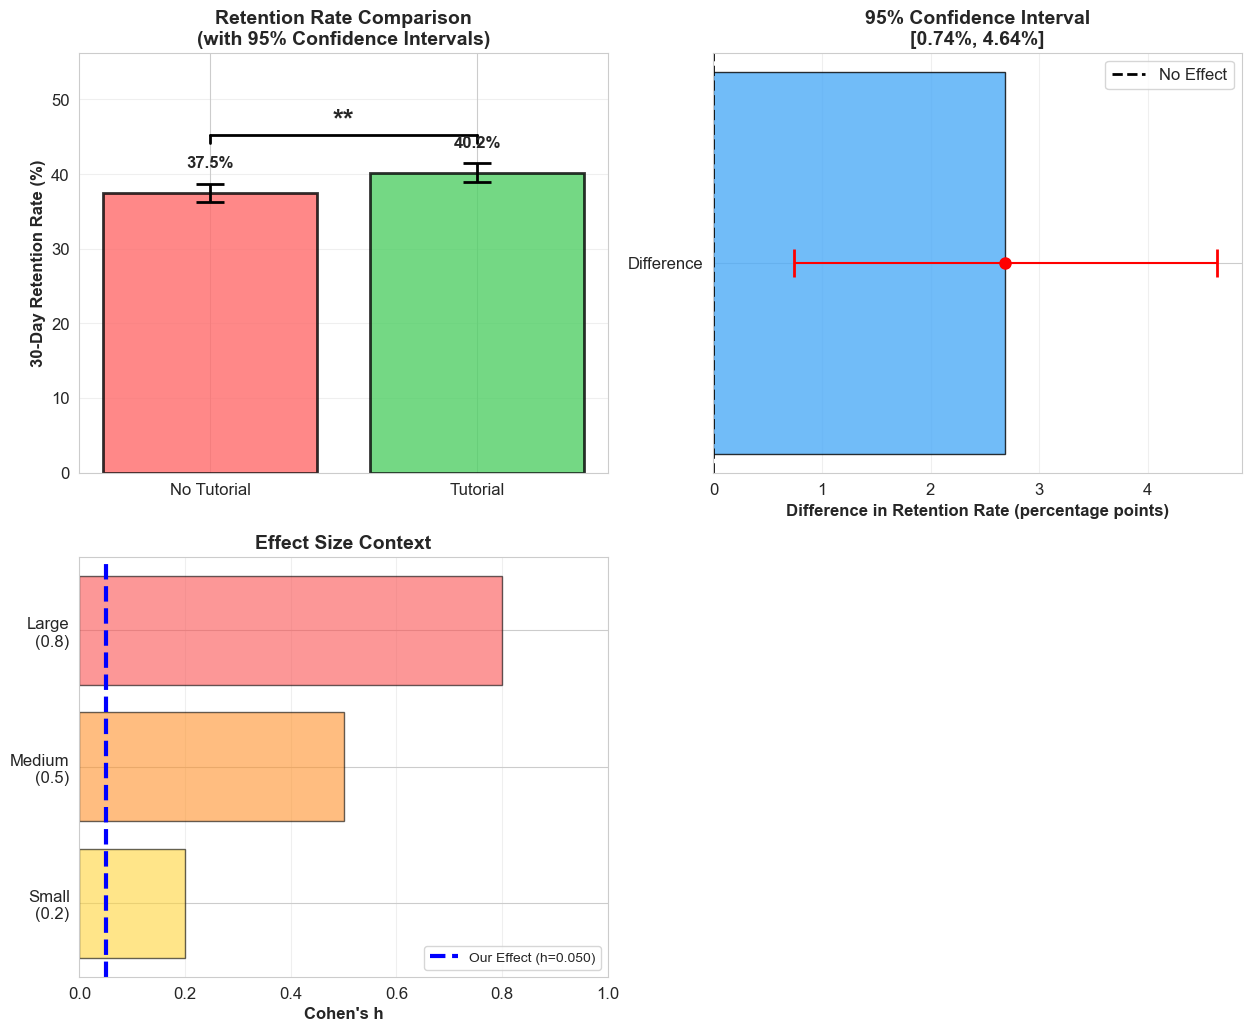

In [22]:
#VISUALIZATION - HYPOTHESIS TEST RESULTS 

import matplotlib.pyplot as plt
from scipy import stats as scipy_stats

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Retention Rates with Significance
ax1 = axes[0, 0]
groups = ['No Tutorial', 'Tutorial']
rates = [no_tutorial_retention, tutorial_retention]
colors = ['#ff6b6b', '#51cf66']

bars = ax1.bar(groups, rates, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.errorbar(groups, rates, 
             yerr=[no_tutorial_se * 100 * 1.96, tutorial_se * 100 * 1.96],
             fmt='none', color='black', capsize=10, capthick=2, linewidth=2)

# Add significance indicator
if p_value < 0.05:
    y_max = max(rates) + 5
    ax1.plot([0, 1], [y_max, y_max], 'k-', linewidth=2)
    ax1.plot([0, 0], [y_max - 1, y_max], 'k-', linewidth=2)
    ax1.plot([1, 1], [y_max - 1, y_max], 'k-', linewidth=2)
    
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    else:
        sig_text = '*'
    ax1.text(0.5, y_max + 1, sig_text, ha='center', fontsize=20, fontweight='bold')

ax1.set_ylabel('30-Day Retention Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Retention Rate Comparison\n(with 95% Confidence Intervals)', 
              fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(rates) * 1.4)
ax1.grid(axis='y', alpha=0.3)

for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: Confidence Interval
ax2 = axes[0, 1]
ax2.barh(['Difference'], [observed_diff], color='#4dabf7', alpha=0.8, edgecolor='black')
ax2.errorbar([observed_diff], [0], xerr=[[observed_diff - ci_low_pct], [ci_high_pct - observed_diff]], 
             fmt='o', color='red', capsize=10, capthick=2, markersize=8)
ax2.axvline(0, color='black', linestyle='--', linewidth=2, label='No Effect')
ax2.set_xlabel('Difference in Retention Rate (percentage points)', fontsize=12, fontweight='bold')
ax2.set_title(f'95% Confidence Interval\n[{ci_low_pct:.2f}%, {ci_high_pct:.2f}%]', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Effect Size Visualization
ax3 = axes[1, 0]
effect_sizes = [0.2, 0.5, 0.8]
effect_labels = ['Small\n(0.2)', 'Medium\n(0.5)', 'Large\n(0.8)']
colors_effect = ['#ffd43b', '#ff922b', '#fa5252']

bars_effect = ax3.barh(effect_labels, effect_sizes, color=colors_effect, alpha=0.6, edgecolor='black')
ax3.axvline(abs(h), color='blue', linestyle='--', linewidth=3, label=f'Our Effect (h={abs(h):.3f})')
ax3.set_xlabel("Cohen's h", fontsize=12, fontweight='bold')
ax3.set_title('Effect Size Context', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.set_xlim(0, 1)
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Test Summary Box
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
HYPOTHESIS TEST RESULTS

Test: Two-Proportion Z-Test
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Statistical Results:
  Z-statistic: {z_stat:.4f}
  P-value: {p_value:.6f}
  
  Decision: {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}
  Result: {'STATISTICALLY SIGNIFICANT ✅' if p_value < 0.05 else 'NOT SIGNIFICANT ❌'}

Effect Size:
  Cohen's h: {h:.4f}
  Classification: {effect_interpretation}
  Relative Improvement: {relative_improvement:.1f}%
  
Confidence Interval (95%):
  [{ci_low_pct:.2f}%, {ci_high_pct:.2f}%]
  
Statistical Power:
  Power: {power:.2%}
  Status: {'Adequate ✅' if power >= 0.8 else 'Low ⚠️'}

Conclusion:
  {'Tutorial significantly improves' if p_value < 0.05 else 'No significant evidence that tutorial improves'}
  {'30-day retention by ' + f'{difference:.2f}' + ' percentage points' if p_value < 0.05 else 'retention'}
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('phase4_hypothesis_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Hypothesis test visualization saved as 'phase4_hypothesis_test_results.png'")

In [26]:
# SEGMENTED HYPOTHESIS TESTS

print("SEGMENTED ANALYSIS BY EXPERIENCE LEVEL")

# Run separate tests for each experience level
experience_levels = df['experience_level'].unique()

segment_results = []

for exp_level in ['new', 'intermediate', 'expert']:
    print(f"\n{'─'*60}")
    print(f"TESTING: {exp_level.upper()} USERS")
    print(f"{'─'*60}")
    
    # Filter data for this experience level
    df_segment = df[df['experience_level'] == exp_level]
    
    # Group by tutorial
    seg_stats = df_segment.groupby('completed_tutorial')['returned_within_30days'].agg([
        ('n', 'count'),
        ('returned', 'sum'),
        ('rate', 'mean')
    ])
    
    # Prepare for test
    seg_counts = np.array([
        seg_stats.loc[1, 'returned'],  # Tutorial
        seg_stats.loc[0, 'returned']   # No tutorial
    ])
    
    seg_nobs = np.array([
        seg_stats.loc[1, 'n'],
        seg_stats.loc[0, 'n']
    ])
    
    # Run test
    seg_z, seg_p = proportions_ztest(seg_counts, seg_nobs, alternative='larger')
    
    # Calculate effect size
    seg_p1 = seg_stats.loc[1, 'rate']
    seg_p2 = seg_stats.loc[0, 'rate']
    seg_h = cohens_h(seg_p1, seg_p2)
    seg_diff = (seg_p1 - seg_p2) * 100
    
    print(f"Tutorial: {seg_p1*100:.1f}% ({int(seg_counts[0])}/{int(seg_nobs[0])})")
    print(f"No Tutorial: {seg_p2*100:.1f}% ({int(seg_counts[1])}/{int(seg_nobs[1])})")
    print(f"Difference: {seg_diff:.2f} pp")
    print(f"P-value: {seg_p:.4f} {'Significant' if seg_p < 0.05 else 'Not significant'}")
    print(f"Cohen's h: {seg_h:.4f}")
    
    segment_results.append({
        'Experience_Level': exp_level,
        'Tutorial_Retention': f"{seg_p1*100:.1f}%",
        'No_Tutorial_Retention': f"{seg_p2*100:.1f}%",
        'Difference': f"{seg_diff:.2f} pp",
        'P_Value': f"{seg_p:.4f}",
        'Significant': 'Yes' if seg_p < 0.05 else 'No',
        'Cohens_h': f"{seg_h:.4f}"
    })

# Create summary table
segment_df = pd.DataFrame(segment_results)

print("SEGMENTED RESULTS SUMMARY")
print(segment_df.to_string(index=False))

segment_df.to_csv('segmented_analysis_results.csv', index=False)
print("\n Segmented results saved")

SEGMENTED ANALYSIS BY EXPERIENCE LEVEL

────────────────────────────────────────────────────────────
TESTING: NEW USERS
────────────────────────────────────────────────────────────
Tutorial: 40.6% (1207/2976)
No Tutorial: 38.3% (779/2033)
Difference: 2.24 pp
P-value: 0.0557 Not significant
Cohen's h: -0.0613

────────────────────────────────────────────────────────────
TESTING: INTERMEDIATE USERS
────────────────────────────────────────────────────────────
Tutorial: 38.7% (700/1807)
No Tutorial: 36.8% (433/1177)
Difference: 1.95 pp
P-value: 0.1417 Not significant
Cohen's h: -0.0586

────────────────────────────────────────────────────────────
TESTING: EXPERT USERS
────────────────────────────────────────────────────────────
Tutorial: 41.5% (498/1201)
No Tutorial: 36.5% (294/806)
Difference: 4.99 pp
P-value: 0.0125 Significant
Cohen's h: -0.0090
SEGMENTED RESULTS SUMMARY
Experience_Level Tutorial_Retention No_Tutorial_Retention Difference P_Value Significant Cohens_h
             new   